In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from glob import glob
import PIL.Image as Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
import cv2

In [ ]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--n_epoch', type=int, default=200)
parser.add_argument('--batch_size', type=int, default=64)

# 識別機の方が学習スピードが遅いため、学習率を識別機の方を高く設定。
# そうすることによって、生成機と識別機の訓練回数を1:1にできる。
parser.add_argument('--lr_g', type=float, default=1e-4)
parser.add_argument('--lr_d', type=float, default=4e-4)

# parser.add_argument('--nch_g', type=int, default=32)
# parser.add_argument('--nch_g', type=int, default=64)
parser.add_argument('--nch_g', type=int, default=128)
# parser.add_argument('--nch_d', type=int, default=32)
# parser.add_argument('--nch_d', type=int, default=64)
parser.add_argument('--nch_d', type=int, default=128)
parser.add_argument('--z_dim', type=int, default=100)
parser.add_argument('--beta1', type=float, default=0.0)
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, beta1=0.0, lr_d=0.0004, lr_g=0.0001, n_epoch=200, nch_d=128, nch_g=128, z_dim=100)


In [ ]:
from torch.utils.data import Dataset
from PIL import ImageGrab

class ImageDataset(Dataset):
  def __init__(self, transform=None):
    super().__init__()
    self.file_list = glob('drive/MyDrive/Lung_Nodule/PickUp_img/*.jpg')
    self.transform = transform

  def __getitem__(self, index):
    if self.transform is not None:
      img = self.transform(Image.open(self.file_list[index]))
    else:
      img = Image.open(self.file_list[index])
    return img

  def __len__(self):
    return len(self.file_list)

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    # チャネルを1/8に圧縮。
    out_channels = in_channels // 8
    self.fx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    self.gx_1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    self.hx_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    #学習するパラメータの初期値を0に設定。
    self.gamma = nn.Parameter(torch.zeros(1))
    self.softmax = nn.Softmax(dim=-2)

  def forward(self, x):
    B, C, H, W = x.size()
    # viewで、1xn or nx1の行列にしている。
    # permuteは転置
    fx = self.fx_1x1(x).view(B, -1, H * W).permute(0, 2, 1)
    gx = self.gx_1x1(x).view(B, -1, H * W)
    hx = self.hx_1x1(x).view(B, -1, H * W)
    # bmmはバッチごとに行列積を計算　
    s_mtx = torch.bmm(fx, gx)
    # softmaxを使って縦に規格化。
    attention = self.softmax(s_mtx)
    o = torch.bmm(hx, attention)
    o = o.view(B, -1, H, W)
    out = x + self.gamma * o
    return out

In [ ]:
from torchvision.transforms.transforms import CenterCrop
import torchvision.transforms as transforms
transform = transforms.Compose([
                              #  transforms.Resize((32, 32)),
                               transforms.Resize((64, 64)),
                              # transforms.Resize((128, 128)),
                               transforms.ToTensor(),
                               transforms.Normalize(0.5, 0.5)
])

In [ ]:
dataset = ImageDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=opt.batch_size, shuffle=True)
len(dataset), len(dataloader)

(561, 9)

In [ ]:
import torch.nn as nn

# パラメータを初期化する関数を定義
def weights_init(m):
  # m.__class__.__name__ には、conv2などレイヤーの名前？がはいる。
  classname = m.__class__.__name__
  # classname にConvがあれば初期化をするということ。elifも同じ。
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)


In [ ]:
# # 画像サイズ128用

# class Generator2(nn.Module):
#   def __init__(self, self_attention, z_dim=100, ngf=64, nc=3):
#     super().__init__()   
#     # covnvt は転置畳み込み             
#     self.convt1 = self.conv_trans_layers(z_dim, 16 * ngf, 4, 1, 0, True)
#     self.convt2 = self.conv_trans_layers(16 * ngf, 8 * ngf, 4, 2, 1, True)
#     self.convt3 = self.conv_trans_layers(8 * ngf, 4 * ngf, 4, 2, 1, True)
#     self.attention1 = self_attention(4 * ngf)
#     self.convt4 = self.conv_trans_layers(4 * ngf, 2 * ngf, 4, 2, 1, True)
#     self.attention2 = self_attention(2 * ngf)
#     self.convt5 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1, True)
#     self.attention3 = self_attention(ngf)
#     self.convt6 = nn.Sequential(
#         nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
#         nn.Tanh()
#     )

#   #　何回も書くのが面倒なので、メソッドを定義しておく。（上記で使用している。）
#   @staticmethod
#   def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
#     layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]

#     if has_norm:
#       layers.append(nn.BatchNorm2d(out_channels))
#     layers.append(nn.ReLU(inplace=True))
#     net = nn.Sequential(*layers)
#     return net

#   def forward(self, x):
#     out = self.convt1(x)
#     # print(out.shape)
#     out = self.convt2(out)
#     # print(out.shape)
#     out = self.convt3(out)
#     # print(out.shape)
#     out = self.attention1(out)
#     out = self.convt4(out)
#     out = self.attention2(out)
#     out = self.convt5(out)
#     out = self.attention3(out)
#     out = self.convt6(out)
#     return out
    

In [ ]:
# # 画像サイズ128用

# class Discriminator2(nn.Module):
#   def __init__(self, self_attention, nc=3, ndf=64):
#     super().__init__()
#     self.conv1 = self.conv_layers(nc, ndf)
#     self.conv2 = self.conv_layers(ndf, 2 * ndf)
#     self.conv3 = self.conv_layers(2 * ndf, 4 * ndf)
#     self.attention1 = self_attention(4 * ndf)
#     self.conv4 = self.conv_layers(4 * ndf, 8 * ndf)
#     self.attention2 = self_attention(8 * ndf)
#     self.conv5 = self.conv_layers(8 * ndf, 16 * ndf)
#     self.attention3 = self_attention(16 * ndf)
#     self.conv6 = nn.Conv2d(16 * ndf, 1, 4)

#   @staticmethod
#   def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, 
#                   has_batch_norm=False):
#     layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
#     if has_batch_norm :
#       layers.append(nn.BatchNorm2d(out_channels))
#     layers.append(nn.LeakyReLU(0.1, inplace=True))
#     net = nn.Sequential(*layers)
#     return net

#   def forward(self, x):
#     out = self.conv1(x)
#     # print(out.shape)
#     out = self.conv2(out)
#     # print(out.shape)
#     out = self.conv3(out)
#     # print(out.shape)
#     out = self.attention1(out)
#     out = self.conv4(out)
#     out = self.attention2(out)
#     out = self.conv5(out)
#     out = self.attention3(out)
#     out = self.conv6(out)
#     return out



In [ ]:
# # 画像サイズ32用
# class Generator(nn.Module):
#   def __init__(self, self_attention, z_dim=100, ngf=64, nc=1):
#     super().__init__()   
#     # covnvt は転置畳み込み             
#     self.convt1 = self.conv_trans_layers(z_dim, 8 * ngf, 4, 1, 0, True)
#     self.convt2 = self.conv_trans_layers(8 * ngf, 4 * ngf, 4, 2, 1, True)
#     self.attention1 = self_attention(4 * ngf)
#     self.convt3 = self.conv_trans_layers(4 * ngf, 2 * ngf, 4, 2, 1, True)
#     self.attention2 = self_attention(2 * ngf)
#     # self.convt4 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1, True)
#     # self.attention2 = self_attention(ngf)
#     self.convt4 = nn.Sequential(
#         nn.ConvTranspose2d(2 * ngf, nc, 4, 2, 1),
#         nn.Tanh()
#     )

#   #　何回も書くのが面倒なので、メソッドを定義しておく。（上記で使用している。）
#   @staticmethod
#   def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
#     layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]

#     if has_norm:
#       layers.append(nn.BatchNorm2d(out_channels))
#     layers.append(nn.ReLU(inplace=True))
#     net = nn.Sequential(*layers)
#     return net

#   def forward(self, x):
#     out = self.convt1(x)
#     out = self.convt2(out)
#     out = self.attention1(out)
#     out = self.convt3(out)
#     out = self.attention2(out)
#     out = self.convt4(out)
#     print(out.shape)
#     return out
    

In [ ]:
# # 画像サイズ32用
# class Discriminator(nn.Module):
#   def __init__(self, self_attention, nc=1, ndf=64):
#     super().__init__()
#     self.conv1 = self.conv_layers(nc, ndf)
#     self.conv2 = self.conv_layers(ndf, 2 * ndf)
#     self.attention1 = self_attention(2 * ndf)
#     self.conv3 = self.conv_layers(2 * ndf, 4 * ndf)
#     # self.conv4 = self.conv_layers(4 * ndf, 8 * ndf)
#     self.attention2 = self_attention(4 * ndf)
#     self.conv4 = nn.Conv2d(4 * ndf, 1, 4)

#   @staticmethod
#   def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, 
#                   has_batch_norm=False):
#     layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
#     if has_batch_norm :
#       layers.append(nn.BatchNorm2d(out_channels))
#     layers.append(nn.LeakyReLU(0.1, inplace=True))
#     net = nn.Sequential(*layers)
#     return net

#   def forward(self, x):
#     out = self.conv1(x)
#     out = self.conv2(out)
#     out = self.attention1(out)
#     out = self.conv3(out)
#     out = self.attention2(out)
#     out = self.conv4(out)
#     return out


In [ ]:
class Generator(nn.Module):
  def __init__(self, self_attention, z_dim=100, ngf=64, nc=1):
    super().__init__()   
    # covnvt は転置畳み込み             
    self.convt1 = self.conv_trans_layers(z_dim, 8 * ngf, 4, 1, 0, True)
    self.convt2 = self.conv_trans_layers(8 * ngf, 4 * ngf, 4, 2, 1, True)
    self.convt3 = self.conv_trans_layers(4 * ngf, 2 * ngf, 4, 2, 1, True)
    self.attention1 = self_attention(2 * ngf)
    self.convt4 = self.conv_trans_layers(2 * ngf, ngf, 4, 2, 1, True)
    self.attention2 = self_attention(ngf)
    self.convt5 = nn.Sequential(
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
        nn.Tanh()
    )

  #　メソッドを定義。（上記で使用。）
  @staticmethod
  def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm):
    layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]

    if has_norm:
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.ReLU(inplace=True))
    net = nn.Sequential(*layers)
    return net

  def forward(self, x):
    out = self.convt1(x)
    # print(out.shape)
    out = self.convt2(out)
    # print(out.shape)
    out = self.convt3(out)
    # print(out.shape)
    out = self.attention1(out)
    out = self.convt4(out)
    out = self.attention2(out)
    out = self.convt5(out)
    return out
    

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, self_attention, nc=1, ndf=64):
    super().__init__()
    self.conv1 = self.conv_layers(nc, ndf)
    self.conv2 = self.conv_layers(ndf, 2 * ndf)
    self.conv3 = self.conv_layers(2 * ndf, 4 * ndf)
    self.attention1 = self_attention(4 * ndf)
    self.conv4 = self.conv_layers(4 * ndf, 8 * ndf)
    self.attention2 = self_attention(8 * ndf)
    self.conv5 = nn.Conv2d(8 * ndf, 1, 4)

  @staticmethod
  def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, 
                  has_batch_norm=False):
    layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
    if has_batch_norm :
      layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.1, inplace=True))
    net = nn.Sequential(*layers)
    return net

  def forward(self, x):
    out = self.conv1(x)
    # print(out.shape)
    out = self.conv2(out)
    # print(out.shape)
    out = self.conv3(out)
    # print(out.shape)
    out = self.attention1(out)
    out = self.conv4(out)
    out = self.attention2(out)
    out = self.conv5(out)
    return out



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
netG = Generator(self_attention=SelfAttention, z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
# apply関数を使ってウェイトを初期化。
netG.apply(weights_init)
print(netG)

netD = Discriminator(self_attention=SelfAttention, nc=1, ndf=opt.nch_d).to(device)
netD.apply(weights_init)
print(netD)

In [ ]:
# netG = Generator2(self_attention=SelfAttention, z_dim=opt.z_dim, ngf=opt.nch_g).to(device)
# # apply関数を使ってウェイトを初期化。
# netG.apply(weights_init)
# print(netG)

# netD = Discriminator2(self_attention=SelfAttention, nc=3, ndf=opt.nch_d).to(device)
# netD.apply(weights_init)
# print(netD)

In [ ]:
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr_g, betas=(opt.beta1, 0.999), weight_decay=1e-5)
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr_d, betas=(opt.beta1, 0.999), weight_decay=1e-5)


In [ ]:
def save_params(file_path, epoch, netD, netG):
  torch.save(
      netG.state_dict(),
      file_path + '/g_{:04d}.pth'.format(epoch)
  )
  torch.save(
      netD.state_dict(),
      file_path + '/d_{:04d}.pth'.format(epoch)
  )

In [ ]:
model_name = 'SAGAN'
f_path_result = 'drive/MyDrive/result/{}'.format(model_name)
f_path_params = 'drive/MyDrive/params/{}'.format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)


In [ ]:
lossesD = []
lossesG = []
raw_lossesD = []
raw_lossesG = []
relu = torch.nn.ReLU()

for epoch in range(opt.n_epoch):
  running_lossD = 0.0
  running_lossG = 0.0
  for i, real_imgs in enumerate(tqdm.tqdm(dataloader, position=0)):
    real_imgs = real_imgs.to(device)
    # 最後のdataloaderバッチサイズは指定したバッチサイズにならないので,毎回バッチサイズを取得。
    batch_size = real_imgs.size()[0]
    noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

    # train Discriminator
    netD.zero_grad()
    output = netD(real_imgs)
    # lossをヒンジ損失へ
    lossD_real = torch.mean(relu(1.0 - output))

    fake_imgs = netG(noise)
    # 識別機を訓練する際は、Generatorは更新しない。detachでfakeimgsを切り離す。
    output = netD(fake_imgs.detach())
    lossD_fake = torch.mean(relu(1.0 + output))

    lossD = lossD_real + lossD_fake
    lossD.backward()
    optimizerD.step()


    # train Generaator
    netG.zero_grad()
    output = netD(fake_imgs)
    # lossG = criterion(output, labels_real)
    lossG = -torch.mean(output)
    lossG.backward()
    optimizerG.step()


    # save losses
    running_lossD += lossD.item()
    running_lossG += lossG.item()
    raw_lossesD.append(lossD.item())
    raw_lossesG.append(lossG.item())
  running_lossD /= len(dataloader)
  running_lossG /= len(dataloader)
  print('epoch: {}, lossD: {}, lossG: {}'.format(epoch, running_lossD, running_lossG))
  lossesD.append(running_lossD)
  lossesG.append(running_lossG)


  # show fake imgs
  # 24枚の画像を取ってきている。
  # 0.5で明るさを調整している。
  grid_imgs = vutils.make_grid(fake_imgs[:24].detach() + 0.5)
  grid_imgs_arr = grid_imgs.cpu().numpy()
  plt.imshow(np.transpose(grid_imgs_arr, (1, 2, 0)))
  plt.show()

  # save imgs & parameters
  # 0.5で明るさを調整している。
  vutils.save_image(fake_imgs + 0.5, f_path_result + '/{}.jpg'.format(epoch))
  if epoch % 50 == 0:
    save_params(f_path_params, epoch, netD, netG)



Text(0.5, 1.0, 'lossG')

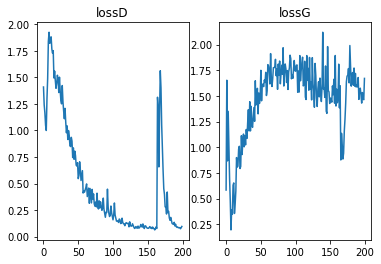

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].plot(lossesD)
ax[0].set_title('lossD')
ax[1].plot(lossesG)
ax[1].set_title('lossG')

In [ ]:
# モデルをロード
state_g = torch.load('drive/MyDrive/params/SAGAN/g_0100.pth')
state_d = torch.load('drive/MyDrive/params/SAGAN/d_0100.pth')
netG.load_state_dict(state_g)
netD.load_state_dict(state_d)


<All keys matched successfully>

In [ ]:
noise = torch.randn(64, 100, 1, 1).to(device)
fake_imgs = netG(noise)
fake_imgs.shape

torch.Size([64, 1, 64, 64])

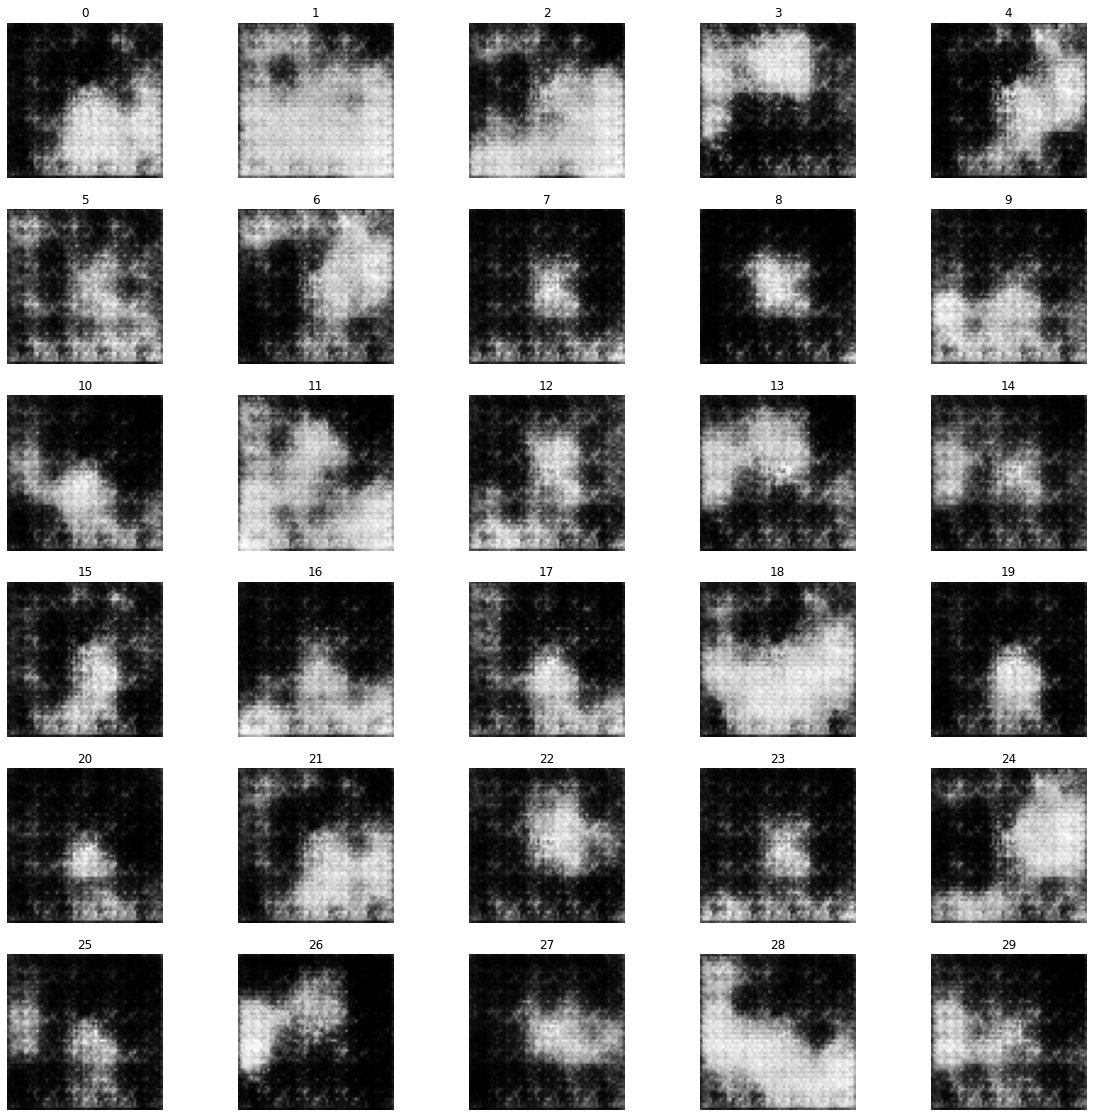

In [ ]:
# fake画像を一覧表示。
# ここから合成に使えそうな腫瘍画像を選んで、ポアソン合成をする。
fake_imgs = fake_imgs.detach().to('cpu').numpy().squeeze()
fig, ax = plt.subplots(6, 5, figsize=(20, 20))
for i in range(30):
  ax[i//5, i%5].imshow(fake_imgs[i], cmap='gray')
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].set_title('{}'.format(i))

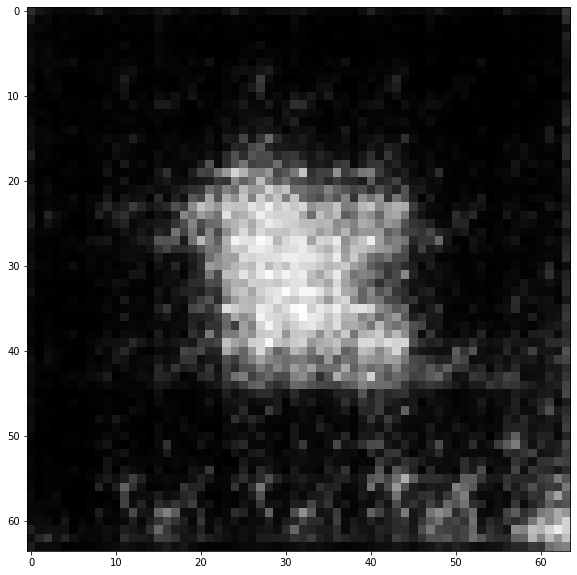

In [ ]:
# 上記から表示したい画像を選択.
idx = 8
fake_img = fake_imgs[idx]
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(fake_img, cmap='gray')

In [ ]:
# # 上記画像から切り取るサイズを選択し、マスク画像を生成。.
# x_min = 12
# x_max = 50
# y_min = 8
# y_max = 54
# H, W = fake_img.shape
# mask_img = np.zeros((H, W))
# mask_img[y_min:y_max, x_min:x_max] = 255
# mask_img = mask_img.astype(np.uint8)

In [ ]:
# fake_imgの画素値を0~255へ、リレンジ
ma = fake_img.max()
mi = fake_img.min()

fake_img = (fake_img - mi) / (ma - mi) * 255
fake_img = fake_img.astype(np.uint8)

In [ ]:
num = 2
Image.fromarray(fake_img).save('drive/MyDrive/GAN_Cancer/fake_img_{}.jpg'.format(num))

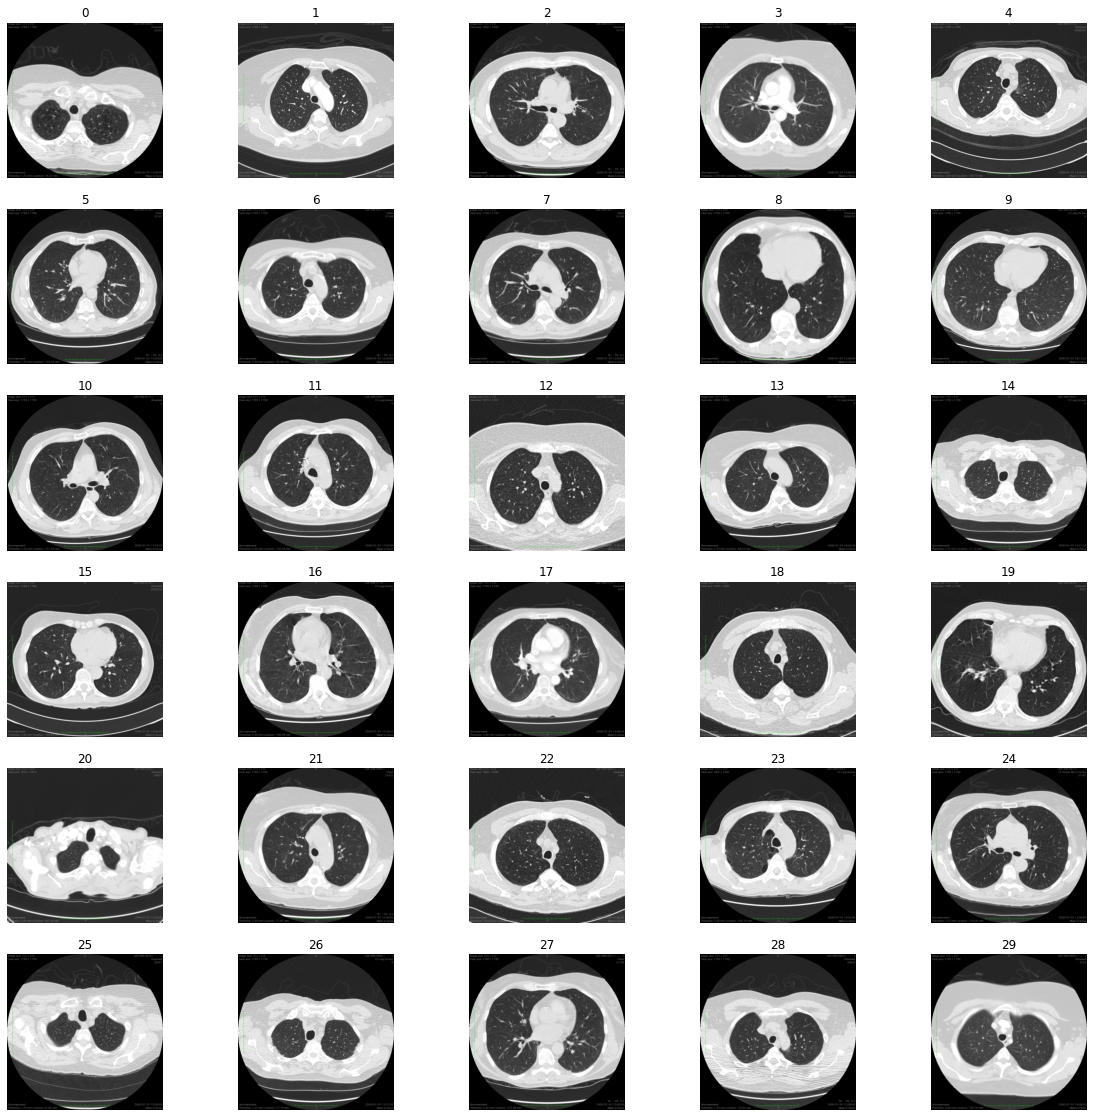

In [ ]:
# 合成元に使えそうなct画像を選ぶ。。
# 表示枚数を決める
number = 30
ct_path = glob('drive/MyDrive/Lung_Nodule_2/Image_Processed/Not_Nodule/*')
num = len(ct_path)
ct_imgs = np.random.choice(ct_path, number,replace=False)

raw = 6 
col = 5
fig, ax = plt.subplots(raw, col, figsize=(20, 20))
for i in range(number):
  ax[i//col, i%col].imshow(Image.open(ct_imgs[i]))
  ax[i//col, i%col].set_title('{}'.format(i))
  ax[i//col, i%col].axis('off')

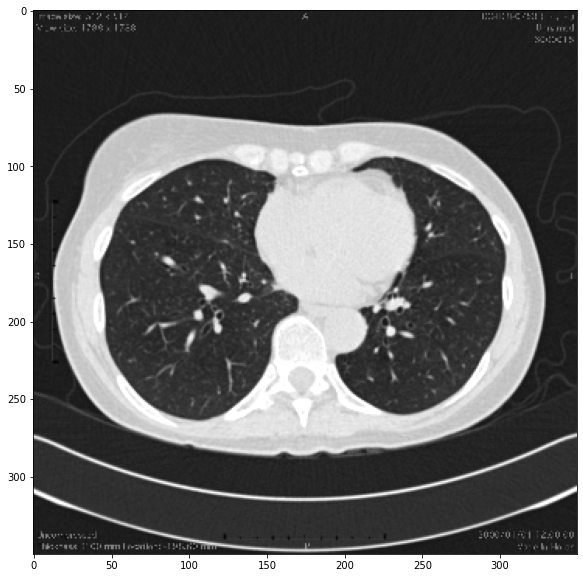

In [ ]:
# 表示したいct画像のindexを指定。
idx = 15

ct_img = np.array(Image.open(ct_imgs[idx]))
ct_img = cv2.resize(ct_img, (350,350))[:,:,0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ct_img, cmap='gray')

In [ ]:
# 選んだ合成元ct画像を保存。
num = 0
Image.fromarray(ct_img).save('drive/MyDrive/GAN_Cancer/ct_img_{}.jpg'.format(num))

In [ ]:
! pip install pyamg

In [ ]:
# ポアソン合成。

import numpy as np
import scipy.sparse
import PIL.Image
import pyamg

fake_path = 'drive/MyDrive/GAN_Cancer/fake_img_{}.jpg'.format(1)
mask_path = 'drive/MyDrive/GAN_Cancer/mask_img_{}.jpg'.format(1)
ct_path = 'drive/MyDrive/GAN_Cancer/ct_img_{}.jpg'.format(0)
poisson_path = 'drive/MyDrive/GAN_Cancer/poisson_{}.jpg'.format(2)

# 上記画像から腫瘍を生成したい座標を決める。
offset = (200, 240)

# pre-process the mask array so that uint64 types from opencv.imread can be adapted
def prepare_mask(mask):
    if type(mask[0][0]) is np.ndarray:
        result = np.ndarray((mask.shape[0], mask.shape[1]), dtype=np.uint8)
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if sum(mask[i][j]) > 0:
                  
                    result[i][j] = 1
                else:
                    result[i][j] = 0
        mask = result
    return mask

def blend(img_target, img_source, img_mask, offset=(0, 0)):
    # compute regions to be blended
    region_source = (
            max(-offset[0], 0),
            max(-offset[1], 0),
            min(img_target.shape[0]-offset[0], img_source.shape[0]),
            min(img_target.shape[1]-offset[1], img_source.shape[1]))
    region_target = (
            max(offset[0], 0),
            max(offset[1], 0),
            min(img_target.shape[0], img_source.shape[0]+offset[0]),
            min(img_target.shape[1], img_source.shape[1]+offset[1]))
    region_size = (region_source[2]-region_source[0], region_source[3]-region_source[1])

    # clip and normalize mask image
    img_mask = img_mask[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    print(img_mask.shape)
    img_mask = prepare_mask(img_mask)
    img_mask[img_mask==0] = False
    img_mask[img_mask!=False] = True

    # create coefficient matrix
    # np.prod()で全ての要素の積
    # identityで単位行列を作成。
    A = scipy.sparse.identity(np.prod(region_size), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y,x]:
                index = x+y*region_size[1]
                A[index, index] = 4
                if index+1 < np.prod(region_size):
                    A[index, index+1] = -1
                if index-1 >= 0:
                    A[index, index-1] = -1
                if index+region_size[1] < np.prod(region_size):
                    A[index, index+region_size[1]] = -1
                if index-region_size[1] >= 0:
                    A[index, index-region_size[1]] = -1
    # tocsr()で計算ができるようモードに変換。
    A = A.tocsr()
    
    # create poisson matrix for b
    P = pyamg.gallery.poisson(img_mask.shape)

    # for each layer (ex. RGB)
    # for num_layer in range(img_target.shape[2]):
      # get subimages
    t = img_target[region_target[0]:region_target[2],region_target[1]:region_target[3]]
    s = img_source[region_source[0]:region_source[2], region_source[1]:region_source[3]]
    t = t.flatten()
    s = s.flatten()

    # create b
    b = P * s
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if not img_mask[y,x]:
                index = x+y*region_size[1]
                b[index] = t[index]

    # solve Ax = b
    # 線型方程式を解いている
    x = pyamg.solve(A,b,verb=False,tol=1e-10)

    # assign x to target image
    x = np.reshape(x, region_size)
    x[x>255] = 255
    x[x<0] = 0
    x = np.array(x, img_target.dtype)
    print(region_target)
    img_target[region_target[0]:region_target[2],region_target[1]:region_target[3]] = x

    return img_target


def test(offset=None):
    img_mask = np.asarray(PIL.Image.open(mask_path))
    img_mask = img_mask.copy()
    img_mask.flags.writeable = True
    img_source = np.asarray(PIL.Image.open(fake_path))
    # img_source = np.stack([img_source,img_source,img_source],axis=-1)
    img_source = img_source.copy()
    img_source.flags.writeable = True
    img_target = np.asarray(PIL.Image.open(ct_path))
    # img_target = np.stack([img_target,img_target,img_target],axis=-1)
    # img_target = img_target.copy()[:,:,0]
    img_target = img_target.copy()

    img_target.flags.writeable = True
    img_ret = blend(img_target, img_source, img_mask, offset=offset)
    img_ret = PIL.Image.fromarray(np.uint8(img_ret))
    img_ret.save(poisson_path)


if __name__ == '__main__':
    test(offset)

(64, 64, 3)
(200, 240, 264, 304)


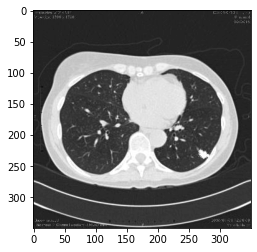

In [ ]:
# ポアソン合成した画像を確認。
plt.imshow(Image.open(poisson_path), cmap='gray')

## ここから合成をよりリアルにしていく。

In [ ]:
mask = np.array(Image.open(mask_path))
ct = np.array(Image.open(ct_path))
poisson_ct = np.array(Image.open(poisson_path))
mask.shape, ct.shape

((64, 64, 3), (350, 350))

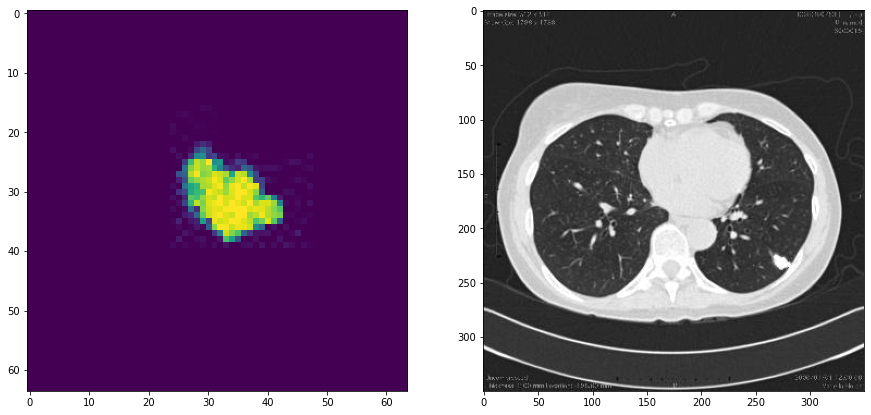

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 20))
ax[0].imshow(mask)
ax[1].imshow(poisson_ct, cmap='gray')

In [ ]:
mask = mask[:, :, 0]
# ピクセル値が０以外の座標を取得。
a, b = np.where(mask != 0)
# 合成をした範囲。
cancer = poisson_ct[200:264, 240:302]

In [ ]:
# 平滑化処理をして、合成感を目立たなくする。（各処理の回数は各々変更。）

# cancer_g = cv2.GaussianBlur(cancer, (3,3), 0)
# cancer_g = cv2.GaussianBlur(cancer, (3,3), 0)
cancer_g = cv2.GaussianBlur(cancer, (3,3), 0)
cancer_g = cv2.medianBlur(cancer, 3)
# cancer_g = cv2.medianBlur(cancer, 5)
# cancer_g = cv2.medianBlur(cancer, 5)

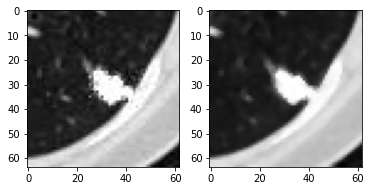

In [ ]:
# ポアソン合成直後と平滑化処理後を比較。

fig, ax = plt.subplots(1, 2)
ax[0].imshow(cancer, cmap='gray')
ax[1].imshow(cancer_g, cmap='gray')

In [ ]:
# 先ほど取得したピクセル値が０以外の座標を使って、平滑化処理をした画像のピクセル値と入れ替える。
for i in range(len(a)):
  cancer[a[i], b[i]] = cancer_g[a[i], b[i]]

# 一応ピクセル値が入れ替わっているか確認。
cancer[a[20], b[20]], cancer_g[a[20], b[20]]

(59, 59)

(-0.5, 349.5, 349.5, -0.5)

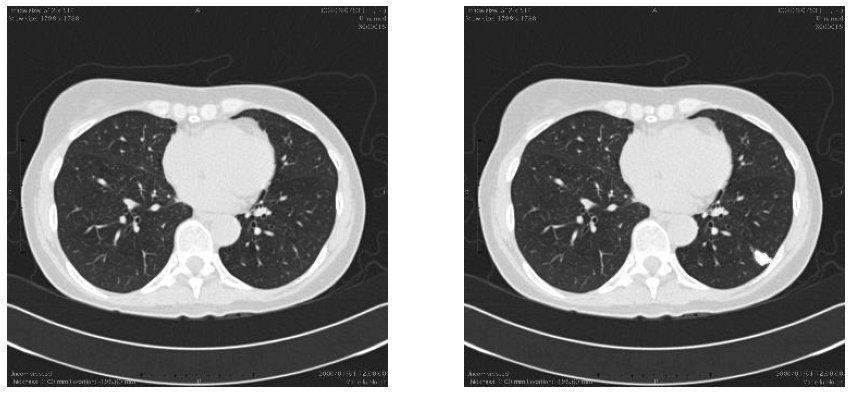

In [ ]:
# 元のct画像に処理した部分を戻す。
# 比較する。（左：ポアソン合成直後、右：ポアソン合成後に局所的に平滑化処理）

poisson_ct[200:264, 240:302] = cancer
fig, ax = plt.subplots(1, 2, figsize=(15, 20))
ax[0].imshow(ct, cmap='gray')
ax[0].axis('off')
ax[1].imshow(poisson_ct, cmap='gray')
ax[1].axis('off')

In [ ]:
Image.fromarray(ct).save('drive/MyDrive/GAN_Cancer/poisson_smothing_0.jpg')